In [22]:
import pandas as pd

df = pd.read_csv('preprocessed_firma1_call_meta.csv')
df

,Date,Underlying,Time_to_Expiration,Strike_Price,Option_Price
0,2024-11-08,589.34,0.057495,280.0,307.26
1,2024-11-13,580.00,0.043806,280.0,300.20
2,2024-11-12,584.82,0.046543,300.0,287.50
3,2024-11-14,577.16,0.041068,300.0,278.00
4,2024-11-15,554.08,0.038330,300.0,253.76
...,...,...,...,...,...
1498,2024-11-05,572.43,0.065708,850.0,0.04
1499,2024-11-11,583.17,0.049281,850.0,0.01
1500,2024-11-12,584.82,0.046543,850.0,0.01
1501,2024-11-13,580.00,0.043806,850.0,0.01


In [23]:
df['Risk_free'] = 4.4710
df

,Date,Underlying,Time_to_Expiration,Strike_Price,Option_Price,Risk_free
0,2024-11-08,589.34,0.057495,280.0,307.26,4.471
1,2024-11-13,580.00,0.043806,280.0,300.20,4.471
2,2024-11-12,584.82,0.046543,300.0,287.50,4.471
3,2024-11-14,577.16,0.041068,300.0,278.00,4.471
4,2024-11-15,554.08,0.038330,300.0,253.76,4.471
...,...,...,...,...,...,...
1498,2024-11-05,572.43,0.065708,850.0,0.04,4.471
1499,2024-11-11,583.17,0.049281,850.0,0.01,4.471
1500,2024-11-12,584.82,0.046543,850.0,0.01,4.471
1501,2024-11-13,580.00,0.043806,850.0,0.01,4.471


In [27]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import pandas as pd

# Black-Scholes formula for call option price
def black_scholes_call(S, K, T, r, sigma):
    try:
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return call_price
    except Exception as e:
        return np.nan  # Handle any unexpected errors gracefully

# Function to calculate implied volatility
def implied_volatility(S, K, T, r, market_price):
    # Define the objective function for root finding
    def objective_function(sigma):
        return black_scholes_call(S, K, T, r, sigma) - market_price
    
    try:
        # Check if the market price is realistic
        theoretical_price_low = black_scholes_call(S, K, T, r, 1e-6)
        theoretical_price_high = black_scholes_call(S, K, T, r, 5)

        if not (theoretical_price_low <= market_price <= theoretical_price_high):
            return np.nan  # Return NaN if the market price is out of range

        # Use Brent's method to find the root
        implied_vol = brentq(objective_function, 1e-6, 5)
        return implied_vol
    except Exception as e:
        # Handle errors in root finding (e.g., no root in interval)
        return np.nan

# Calculate implied volatility for each row in the dataset
df['Implied_Volatility'] = df.apply(lambda row: implied_volatility(
    row['Underlying'], 
    row['Strike_Price'], 
    row['Time_to_Expiration'], 
    row['Risk_free'] / 100, 
    row['Option_Price']), axis=1)

print(df)


            Date  Underlying  Time_to_Expiration  Strike_Price  Option_Price  \
0     2024-11-08      589.34            0.057495         280.0        307.26   
1     2024-11-13      580.00            0.043806         280.0        300.20   
2     2024-11-12      584.82            0.046543         300.0        287.50   
3     2024-11-14      577.16            0.041068         300.0        278.00   
4     2024-11-15      554.08            0.038330         300.0        253.76   
...          ...         ...                 ...           ...           ...   
1498  2024-11-05      572.43            0.065708         850.0          0.04   
1499  2024-11-11      583.17            0.049281         850.0          0.01   
1500  2024-11-12      584.82            0.046543         850.0          0.01   
1501  2024-11-13      580.00            0.043806         850.0          0.01   
1502  2024-11-20      565.52            0.024641         850.0          0.01   

      Risk_free  Implied_Volatility  
0

In [40]:
df_cleaned.to_csv('call_option_data.csv')

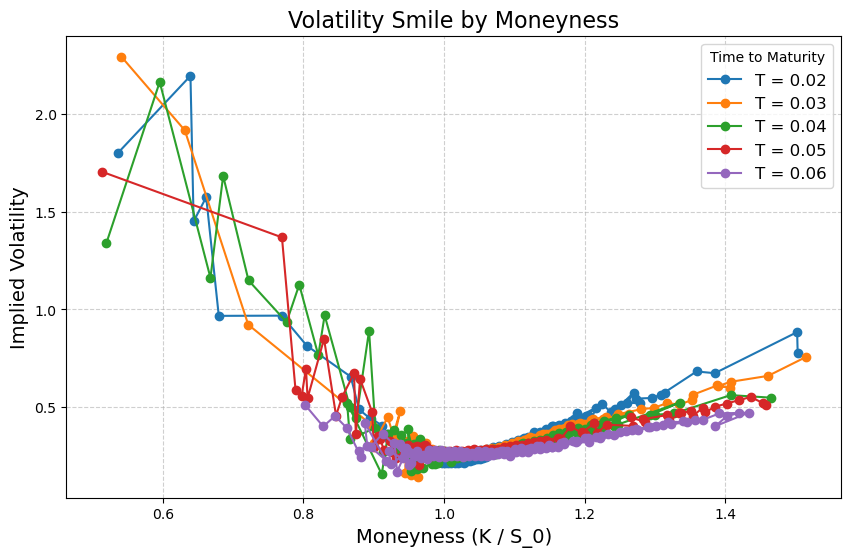

In [39]:
import matplotlib.pyplot as plt


# Clean the data (remove rows with NA implied volatilities)
df_cleaned = df.dropna()

# Sort the data by strike price for smooth plotting
df_cleaned = df_cleaned.sort_values(by='Strike_Price')

# Calculate Moneyness (K / S_0)
df_cleaned['Moneyness'] = df_cleaned['Strike_Price'] / df_cleaned['Underlying']

# Group by Time to Expiration
df_cleaned['Rounded_Time_to_Expiration'] = df['Time_to_Expiration'].round(2)
groups = df_cleaned.groupby('Rounded_Time_to_Expiration')

# Plot
plt.figure(figsize=(10, 6))
i = 0
for T, group in groups:
    plt.plot(group['Moneyness'], group['Implied_Volatility'], marker='o', label=f'T = {T}')
    i += 1
    if i == 5:
        break

# Add labels and legend
plt.title('Volatility Smile by Moneyness', fontsize=16)
plt.xlabel('Moneyness (K / S_0)', fontsize=14)
plt.ylabel('Implied Volatility', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Time to Maturity', fontsize=12)
plt.show()
